In [3]:
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const

### This tutorial demonstrates how to create a simple tranmission spectrum

Here we are using simple analytical equations from [Heng & Kitzmann (2017)](https://academic.oup.com/mnras/article/470/3/2972/3866925), specificallly the modified form from [Gibson et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.493.2215G/abstract):

$$
R(\lambda)=R_{0}+H\left[\gamma+\ln \left(\frac{P_{0}}{mg} \sqrt{\frac{2 \pi R_{0}}{H}}\right)\right] + H \ln\sum_j \chi_j \sigma_j(\lambda).
$$

See the paper for further details, but this is in some sense nothing more than Beer's law applied to the geometry of a planetary transit, that takes into account the exponential decrease in the density of the atmosphere with altitude, and assumes an isothermal, (chemically) well-mixed atmosphere.

The key parameters are the atmospheric scale height $H$, the absorption cross-section as a function of wavelength ($\sigma_j(\lambda)$) due to species $j$, and the volume mixing ratio of that species ($\chi_j$). The remaining parameters are constants that set the overall level ($P_0$ is reference pressure at reference radius $R_0$, $m$ is mean molecular weight of atmosphere, and $g$ is 'surface' gravity, $\gamma = 0.56$ is a dimensionless constant). $m \approx 2.3 \times \rm{m_{H}}$ (mass of hydrogen atom) for Jupiter, which we typically assume for hot Jupiters that are dominated by molecular hydrogen.

The atmospheric scale height is given by:
$$
H = \frac{kT}{mg},
$$
which we assume to be constant (despite the varying temperature, gravity, and chemistry).

You will need a file containing the cross-sections: x_FeI_2500K_cm2.npy, which can be downloaded from here: https://tcdud-my.sharepoint.com/:u:/g/personal/gibsonne_tcd_ie/Ebw-xD_Ir1lEgqf8_-BHIrYBdqtji_czuuFr5W4nam8ASw?e=i7XsMd

This tutorial will assume the only absorber in the atmosphere is neutral Fe at 2500K (with cross-section stored in the file x_FeI_2500K_cm2.npy), as well as a cloud deck at a specific altitude (we assume clouds block light at all colours).

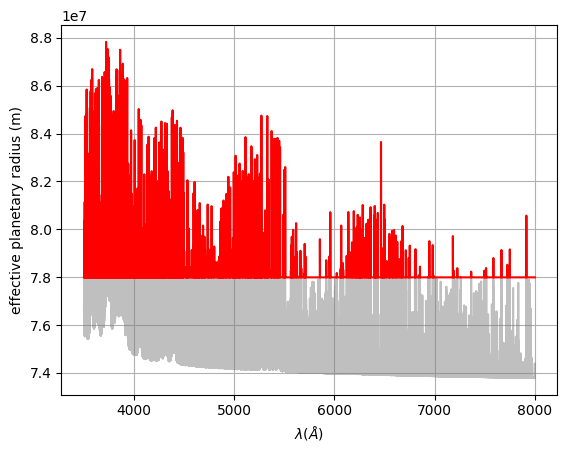

In [ ]:
# import h5py
# with h5py.File('/Users/ng/MyPython/PlanetAtmos/LineLists/CrossSections.h5','r') as F:
#   w_input = F['w_vacuum'][()]
#   w_index = (w_input>3500) * (w_input<8000) #filter out unnecessary wavelengths
#   w_model = w_input[w_index]
#   sigma = F['2500K/spec_Fe_I'][w_index] / 1e4 #m2
# np.save('x_FeI_2500K_m2.npy',np.array([w_model,sigma]))

#get the wavelength + cross-section from the provided line list (in m^-2)    
wl,sigma = np.load('x_FeI_2500K_m2.npy')
chi_FeI = 1e-6 #define abundance of FeI in volume mixing ratio

Pcloud = 0.1 #define altitude of clouds, in bar
T = 3000 #atmospheric temperature in K, this is only used to calculate the scale height
  #ie can be adjusted separately to the opacity temperature

Rstar = 1.756*const.R_sun.value #stellar radius in m
Mpl = 0.894*const.M_jup.value #planet mass in kg
Rpl = 0.10852*const.R_sun.value #planet radius in m
mmw = 2.3 *const.m_p.value #mean molecular weight kg
gamma = 0.54

#derive quantities
g = const.G.value * Mpl / Rpl**2 #surface gravity of planet
Hs = const.k_B.value * T / (2.3*const.m_p.value * g) #calculate atmospheric scale height
P0 = 10. * 100000. #reference pressure, bar to Pa at R0
R0 = Rpl #reference radius

#calculate constant of model
K = R0 + Hs * (gamma + np.log(P0 / g) - np.log(mmw) + 0.5*np.log(2.*np.pi*R0/Hs) )

#calcualte the transmission spectrum
r_species = K + Hs * np.log(chi_FeI * sigma) #this is in units of m

#calculate radius of cloud deck, which forms the continuum
r_continuum = Hs * np.log(P0/Pcloud/100000.) + R0

#truncate the transmission spectrum at the altitude of the cloud deck (as atmosphere is completely opaque lower down)
r = np.maximum(r_species,r_continuum)

#finally make a plot of the transmission spectrum
f,a = plt.subplots(1)
a.plot(wl,r_species,'0.5',alpha=0.5)
# a.plot(wl,r_continuum * np.ones(wl.size),'b-')
a.plot(wl,r,'r-')
a.set_xlabel(r'$\lambda (\AA)$')
a.set_ylabel(r'effective planetary radius (m)')
a.grid()

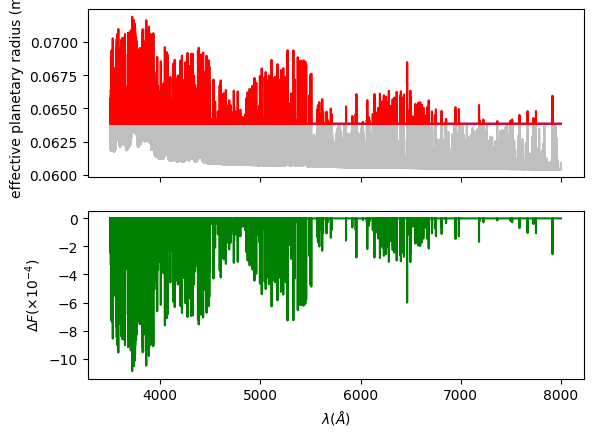

In [7]:
#often we want our tranmission spectrum in different units

#convert to units of Rp/Rs - often used for low-resolution transmission spectra
# as this is what we measure directly from transit light curves
rprs = r / Rstar
rprs_continuum = r_continuum / Rstar
rprs_species = r_species / Rstar

#for high-res, often we want units in negative delta flux
dflux = - (rprs**2 - rprs_continuum**2)

f,a = plt.subplots(2,sharex='all')
a[0].plot(wl,rprs_species,'0.5',alpha=0.5)
a[0].plot(wl,rprs_continuum * np.ones(wl.size),'b-')
a[0].plot(wl,rprs,'r-')
a[0].set_ylabel(r'effective planetary radius (m)')
# a[1].plot(wl,dflux * 10000,'k-')
a[1].set_xlabel(r'$\lambda (\AA)$')
a[1].set_ylabel(r'$\Delta F (\times 10^{-4})$')

#save the model spectrum
np.save('model_FeI_2500K',np.array([wl,dflux]))

#finally, we're going to broaden the template a little by convoluting with a Gaussian kernel
#this allows us to match the template to the real data, e.g. rotation/instrumental broadening
sigma = 2 #stdev of gaussian
g = np.exp(-0.5*np.linspace(-50,50,101)**2 / sigma**2) #create the guassian function
g /= g.sum() #normalise
dflux = np.convolve(g,dflux,'same')
a[1].plot(wl,dflux * 10000,'g-')

#save the model spectrum
np.save('model_FeI_2500K_broadended',np.array([wl,dflux]))


### Explore further

In many cases, we might want to add a 2nd species, or another source of continuum. One important *wavelength dependent* source of continuum is Rayleigh scattering due to molecular hydrogen. We can assume its cross-section is given by:

`sigma_ray = 2.3e-31  * (4300./wl)**4` #cross section in /m2 for H_2, wl in Angstrom

This is a smooth function of wavelength, with enhanced scattering at short wavelenghts. We can also enhance the Rayleigh scattering by multiplying the cross-section by an arbitrary value.

Here are a few things to try in order to make sure you understand the model:
- Vary the cloud deck altitudes
- Vary the abundanc of Fe
- Adjust the scale height of the atmosphere
- Add a 2nd species, in this case Rayleigh scattering (you might need a multiplicative enhancement of ~100 before you see its effects)
